# **Installing Library required for downloading Kaggle dataset**

In [ ]:
! pip install opendatasets

# **Importing Required Libraries**

In [ ]:
import opendatasets as od
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# **Downloading dataset from Kaggle**

In [ ]:
od.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adichoudhary
Your Kaggle Key: ··········


100%|██████████| 149M/149M [00:08<00:00, 18.8MB/s]


# **Getting the path of the training and testing dataset.**

In [ ]:
base_path = os.getcwd()
dataset_path = os.path.join(base_path, os.listdir(base_path)[1])
file_list = os.listdir(dataset_path)
file_list.sort()

x, y = file_list

train_path = os.path.join(dataset_path, y)
test_path = os.path.join(dataset_path, x)

print(train_path, '\n', test_path)


/content/brain-tumor-mri-dataset/Training 
 /content/brain-tumor-mri-dataset/Testing


# **Defining the transformation pipeline**

In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transfroms = tt.Compose([tt.Resize((256,256)),
                               tt.CenterCrop((224,224)),
                                tt.RandomHorizontalFlip(),
                                tt.RandomRotation(25),
                                tt.ToTensor(),
                                tt.Normalize(*stats,inplace=True)])
test_transforms = tt.Compose([tt.Resize((256,256)),
                              tt.CenterCrop((224,224)),
                              tt.ToTensor(),
                              tt.Normalize(*stats)])

# **Getting the images from respective folder into respective datasets**

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(train_path, train_transfroms)
test_ds = ImageFolder(test_path,test_transforms)

print(f"Length of training dataset = {len(train_ds)}\nLength of testing dataset = {len(test_ds)}")

Length of training dataset = 5712
Length of testing dataset = 1311


# **Pytorch Data Loaders**

In [ ]:
batch_size=15
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size,shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Seeing some images of training dataset**

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    helper = {class_idx: class_name for class_name, class_idx in train_ds.class_to_idx.items()}
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)

        for i, item in enumerate(denorm_images[:12]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(item.permute(1, 2, 0))
            class_label = helper[labels[i].item()]
            plt.title(f'Label: {class_label}')
            plt.xticks([])
            plt.yticks([])

        break



<ipython-input-9-821ba2a9b64b>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i + 1)


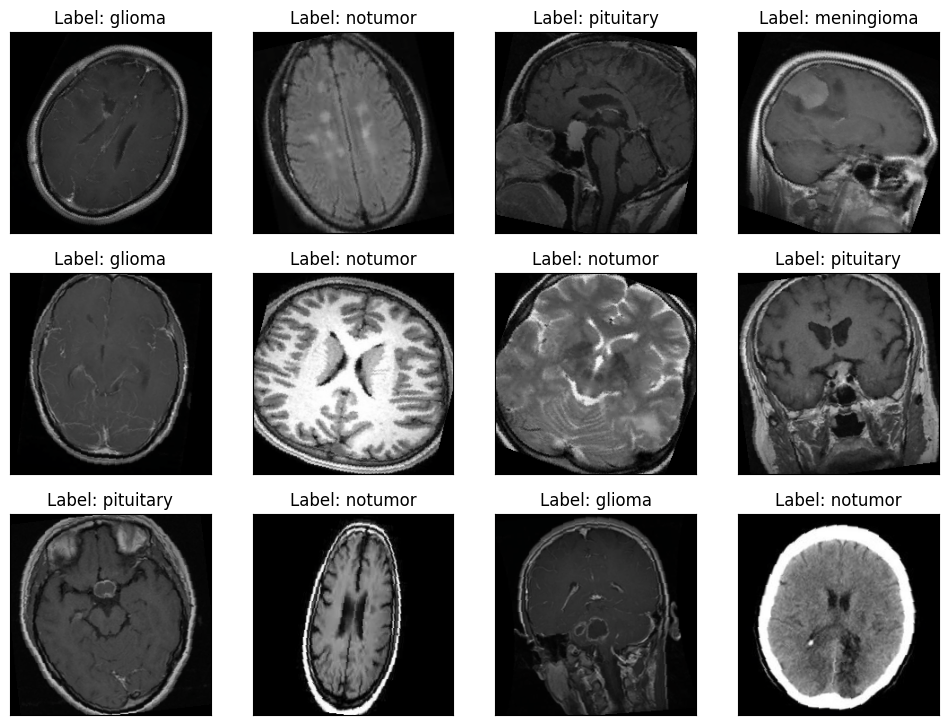

In [ ]:
show_batch(train_dl)

# **Seeing some of images of testing dataset**

<ipython-input-9-821ba2a9b64b>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i + 1)


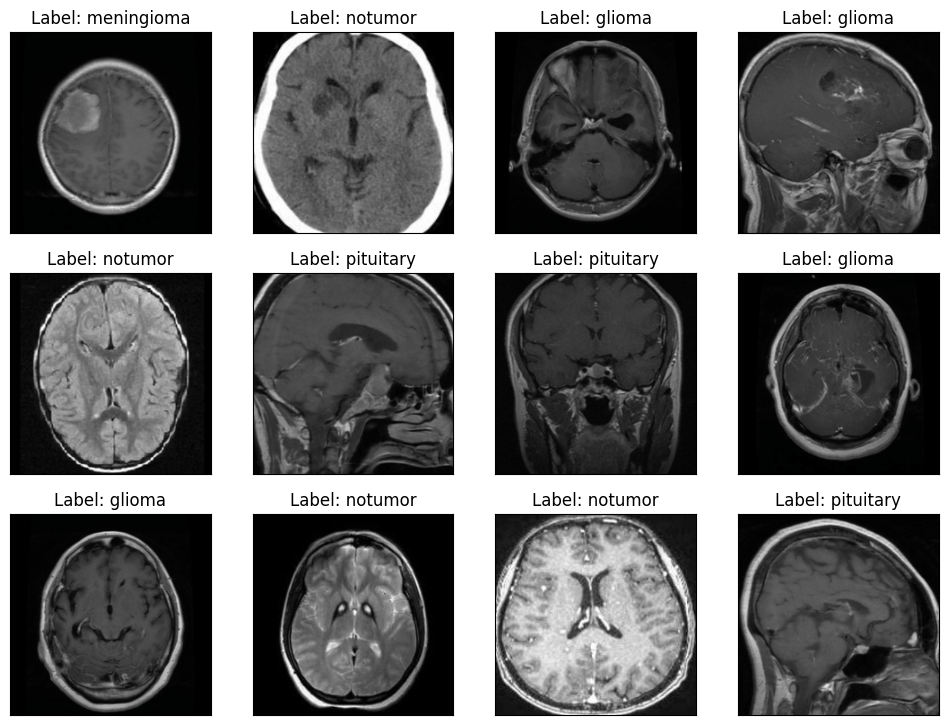

In [ ]:
show_batch(test_dl)

# **Seeing the class distribution in the train dataset**

In [ ]:
def show_class_distribution(dataset,title) -> None:
    class_counts = [0] * len(dataset.classes)

    for _, label in dataset:
        class_counts[label] += 1

    # Plot the pie chart
    plt.pie(class_counts, labels=dataset.classes, autopct='%1.1f%%')
    plt.title(f'Classes distribution in {title}')
    plt.show()

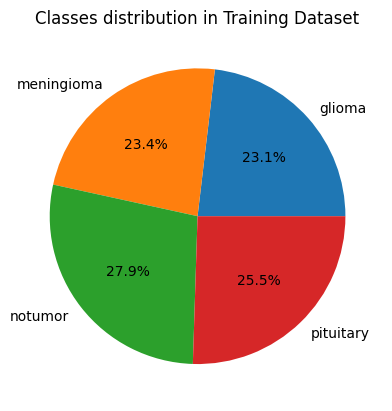

In [ ]:
show_class_distribution(train_ds,'Training Dataset')

# **Seeing the class distribution in the test dataset**

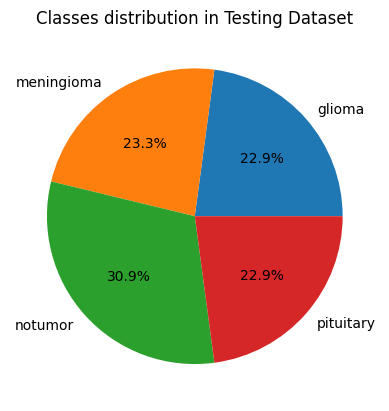

In [ ]:
show_class_distribution(test_ds,'Testing Dataset')

# **Tensor size in train dataset**

In [ ]:
img, label = train_ds[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


# **Tensor size in test dataset**

In [ ]:
img, label = test_ds[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


# **Configuration for using a GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

# **Transferring the train and test loaders data to GPU**

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# **Defining the base model for Image Classification**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Testing phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

class ImageClassificationBase_1(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']))

# **Model no 01 : Using linear layer**

In [ ]:
class Model_1(ImageClassificationBase_1):
    def __init__(self):
        super().__init__()
        self.seq=nn.Sequential(nn.Flatten(),
                               nn.Linear(3*224*224,512),
                               nn.Dropout(0.20),
                               nn.ReLU(inplace=True),
                               nn.Linear(512,4))
    def forward(self,xb):
        out=self.seq(xb)
        return out

model_1=Model_1()
model_1

Model_1(
  (seq): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)

# **Training and testing Model no 1**

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model_1, device)
model_1 = to_device(Model_1(), device)

In [ ]:
%%time
history = fit(1, 0.00005, model_1, train_dl, test_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4575, test_loss: 0.9281, test_acc: 0.6348
CPU times: user 2.9 s, sys: 1.65 s, total: 4.55 s
Wall time: 33.2 s


In [ ]:
num_epochs = 12
opt_func = torch.optim.Adam
lr = 0.00005

In [ ]:
%%time
history = fit(num_epochs, lr, model_1, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 0.9277, test_loss: 0.8488, test_acc: 0.6640
Epoch [1], train_loss: 0.8471, test_loss: 0.8155, test_acc: 0.7140
Epoch [2], train_loss: 0.7975, test_loss: 0.7889, test_acc: 0.7106
Epoch [3], train_loss: 0.7721, test_loss: 0.9178, test_acc: 0.7193
Epoch [4], train_loss: 0.7731, test_loss: 0.8050, test_acc: 0.6769
Epoch [5], train_loss: 0.7468, test_loss: 0.7302, test_acc: 0.7121
Epoch [6], train_loss: 0.7478, test_loss: 0.6542, test_acc: 0.7466
Epoch [7], train_loss: 0.7115, test_loss: 0.6554, test_acc: 0.7443
Epoch [8], train_loss: 0.7079, test_loss: 0.6550, test_acc: 0.7568
Epoch [9], train_loss: 0.7045, test_loss: 0.6386, test_acc: 0.7451
Epoch [10], train_loss: 0.6883, test_loss: 0.6195, test_acc: 0.7595
Epoch [11], train_loss: 0.6913, test_loss: 0.6140, test_acc: 0.7538
CPU times: user 29.5 s, sys: 17.2 s, total: 46.7 s
Wall time: 6min 35s


# **Plotting the testset accuracies**

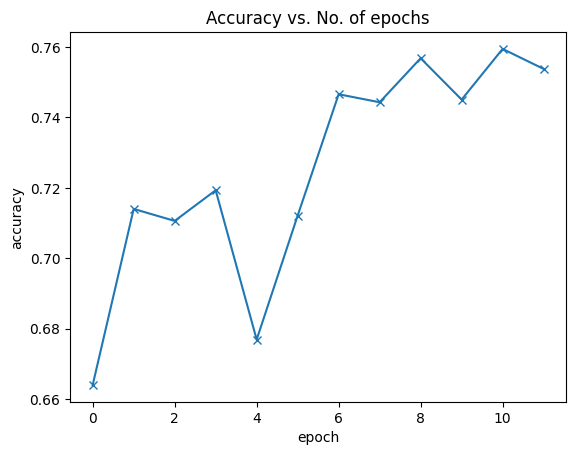

In [ ]:
def plot_accuracies(history):
    accuracies = [x['test_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

## **Plotting the training and testing losses to study the trend**

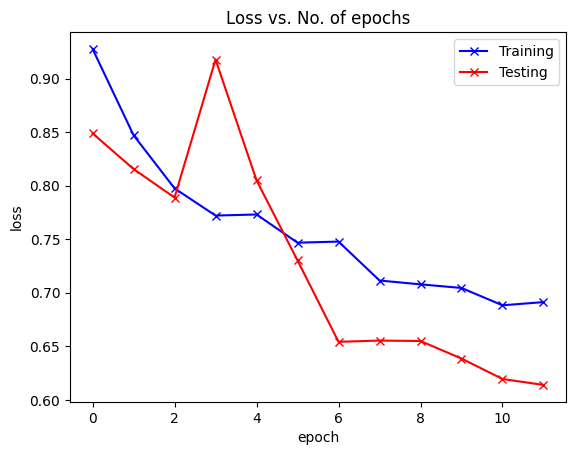

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    test_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(test_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Testing'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

## **Plotting Confusion Matrix**

In [ ]:
def plot_confusion_matrix(model) -> None:
    cmap=plt.cm.Blues
    classes=train_ds.class_to_idx.keys()
    all_predictions = []
    all_labels = []
    for batch in test_dl:
        image_data, labels = batch
        out = model(image_data)
        _, preds = torch.max(out, dim=1)
        preds = [item.item() for item in preds]
        all_predictions.extend(list(preds))

        # Convert the labels tensor to a list of scalars
        labels = labels.tolist()
        all_labels.extend(labels)

    cm = confusion_matrix(all_labels, all_predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


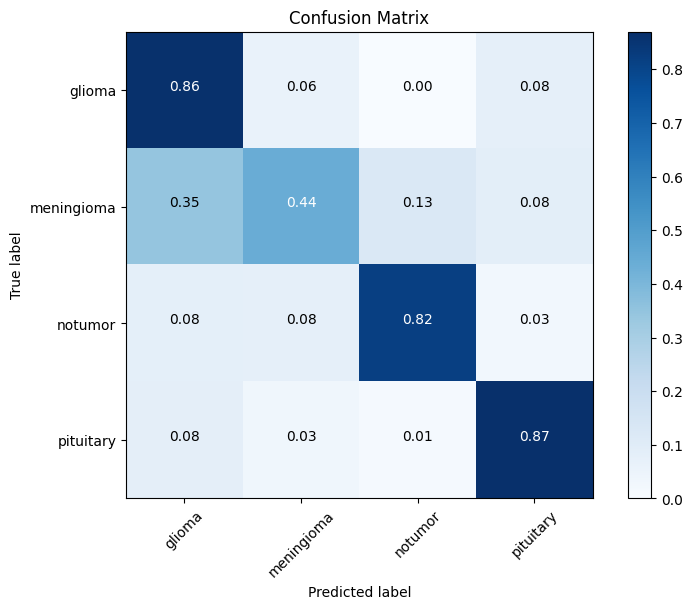

In [ ]:
plot_confusion_matrix(model_1)

# **F1 Score,Precision and Recall**

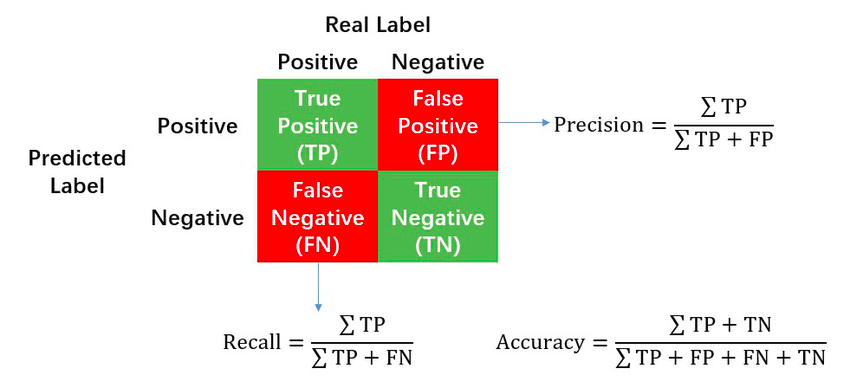

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

def get_f1_prec_recall(model):
    model.eval()
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for inputs, labels in test_dl:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    print(f"Test Set - Precision: {precision:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")


In [ ]:
get_f1_prec_recall(model_1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Set - Precision: 0.7623, F1 Score: 0.7451, Recall: 0.7521


# **Model no 2 : Using Convolution Layers**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase_2(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['test_loss'], result['test_acc']))

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU()]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class Model_2(ImageClassificationBase_2):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Input : 3*224*224
        self.conv1 = conv_block(in_channels, 12) # Output : 12*224*224
        self.conv2 = conv_block(12, 36, pool=True) # Output : 36*112*112


        self.conv3 = conv_block(36,72) # Output : 72*112*112
        self.conv4 = conv_block(72,144, pool=True) # Output : 144*56*56

        self.classifier = nn.Sequential(nn.AvgPool2d(4), # Output : 144*14*14
                                        nn.Flatten(),
                                        nn.Linear(144*14*14,512),
                                        nn.Dropout(0.20),
                                        nn.Linear(512,4))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)

        out = self.conv3(out)
        out = self.conv4(out)

        out = self.classifier(out)

        return out

In [ ]:
model_2 = to_device(Model_2(3, 4), device)
model_2

Model_2(
  (conv1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(12, 36, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(36, 72, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(72, 144, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

# **Training the model**

In [ ]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Testing phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
%%time
history = [evaluate(model_2, test_dl)]
history

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CPU times: user 2.16 s, sys: 710 ms, total: 2.87 s
Wall time: 9.1 s


[{'test_loss': 1.389276146888733, 'test_acc': 0.24924243986606598}]

In [ ]:
epochs = 12
max_lr = 0.0025
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model_2, train_dl, test_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00053, train_loss: 1.1449, test_loss: 0.8920, test_acc: 0.7689
Epoch [1], last_lr: 0.00151, train_loss: 0.6888, test_loss: 0.5595, test_acc: 0.7936
Epoch [2], last_lr: 0.00234, train_loss: 0.5931, test_loss: 0.6273, test_acc: 0.8064
Epoch [3], last_lr: 0.00249, train_loss: 0.5337, test_loss: 0.5304, test_acc: 0.7811
Epoch [4], last_lr: 0.00233, train_loss: 0.4538, test_loss: 0.4412, test_acc: 0.8402
Epoch [5], last_lr: 0.00203, train_loss: 0.3953, test_loss: 0.4882, test_acc: 0.8155
Epoch [6], last_lr: 0.00162, train_loss: 0.3480, test_loss: 0.3611, test_acc: 0.8716
Epoch [7], last_lr: 0.00116, train_loss: 0.3071, test_loss: 0.3170, test_acc: 0.8788
Epoch [8], last_lr: 0.00071, train_loss: 0.2661, test_loss: 0.3205, test_acc: 0.8765
Epoch [9], last_lr: 0.00033, train_loss: 0.2139, test_loss: 0.2308, test_acc: 0.9136
Epoch [10], last_lr: 0.00009, train_loss: 0.1872, test_loss: 0.2074, test_acc: 0.9258
Epoch [11], last_lr: 0.00000, train_loss: 0.1598, test_loss: 0.2

# **Plotting the testset accuracies**

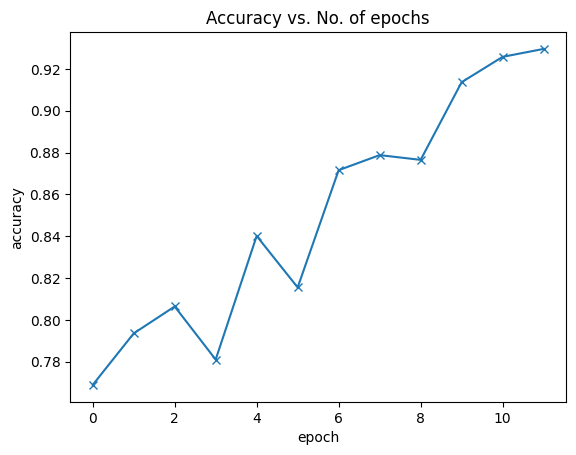

In [ ]:
plot_accuracies(history)

# **Plotting the training and testing losses to study the trend**

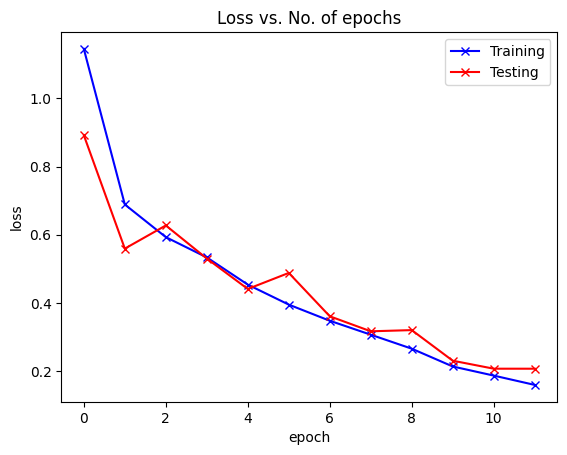

In [ ]:
plot_losses(history)

# **Visualize how the learning rate changed over time, batch-by-batch over all the epochs.**

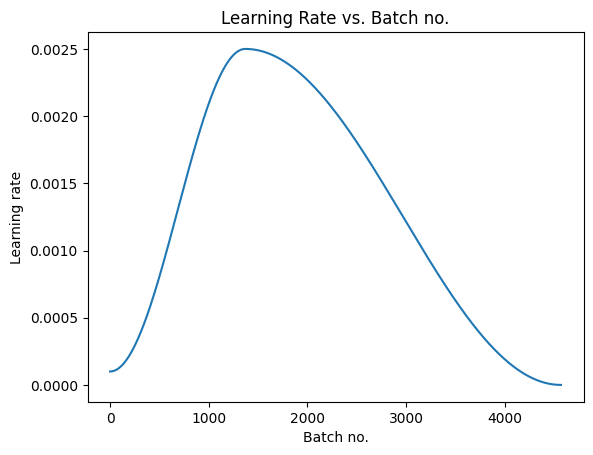

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

# **Plotting the confusion matrix**

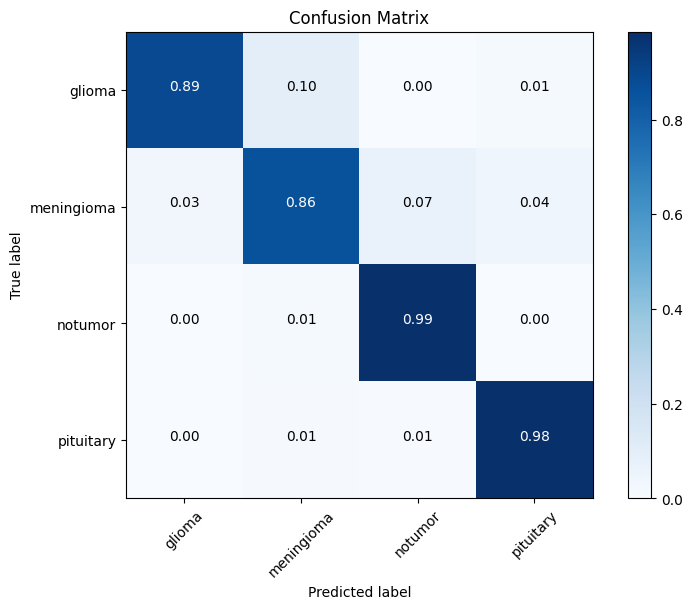

In [ ]:
plot_confusion_matrix(model_2)

# **F1 score,Precision and Recall**

In [ ]:
get_f1_prec_recall(model_2)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Set - Precision: 0.9313, F1 Score: 0.9308, Recall: 0.9314


# **Model no 03 : Building Resnet-18 From Scratch**

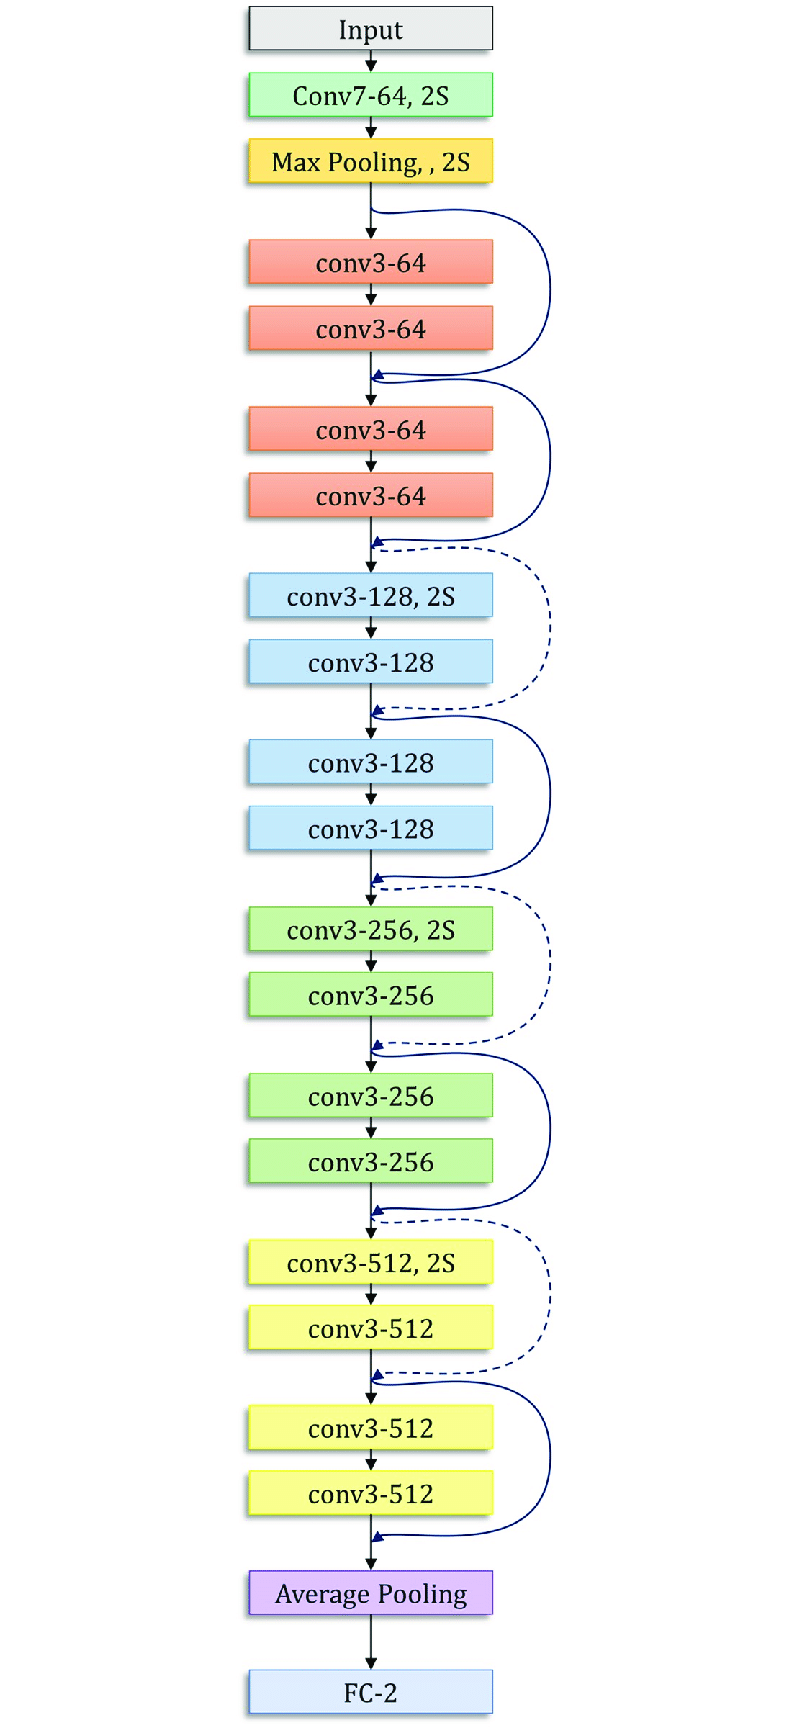

In [ ]:
import torch
import torch.nn as nn

def make_conv_block(input_channels, output_channels, kernel_size, stride):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=1),
              nn.BatchNorm2d(output_channels),
              nn.ReLU()]

    return nn.Sequential(*layers)


class Scratch_Resnet_Model(ImageClassificationBase_2):
    def __init__(self, in_channels, num_classes):
        super(Scratch_Resnet_Model, self).__init__()

        # Input: 3*224*224
        self.layer1 = make_conv_block(in_channels, 64, 7, 2)  # Output: 64*112*112
        self.max_pool_1 = nn.MaxPool2d(2)  # Output: 64*56*56


        self.res1 = nn.Sequential(make_conv_block(64, 64, 3, 1),
                                 make_conv_block(64, 64, 3, 1))  # Output: 64*56*56

        self.res2 = nn.Sequential(make_conv_block(64, 64, 3, 1),
                                 make_conv_block(64, 64, 3, 1))  # Output: 64*56*56

        self.down_grade_1=make_conv_block(64, 128, 3, 2)

        self.res3 = nn.Sequential(make_conv_block(64, 128, 3, 2),
                                 make_conv_block(128, 128, 3, 1))  # Output: 128*28*28

        self.res4 = nn.Sequential(make_conv_block(128, 128, 3, 1),
                                 make_conv_block(128, 128, 3, 1))  # Output: 128*28*28

        self.down_grade_2=make_conv_block(128, 256, 3, 2)

        self.res5 = nn.Sequential(make_conv_block(128, 256, 3, 2),
                                 make_conv_block(256, 256, 3, 1))  # Output: 256*14*14

        self.res6 = nn.Sequential(make_conv_block(256, 256, 3, 1),
                                 make_conv_block(256, 256, 3, 1))  # Output: 256*14*14

        self.down_grade_3=make_conv_block(256, 512, 3, 2)

        self.res7 = nn.Sequential(make_conv_block(256, 512, 3, 2),
                                 make_conv_block(512, 512, 3, 1))  # Output: 512*7*7

        self.res8 = nn.Sequential(make_conv_block(512, 512, 3, 1),
                                 make_conv_block(512, 512, 3, 1))  # Output: 512*7*7

        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                                       nn.Flatten(),
                                       nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.layer1(xb)
        out = self.max_pool_1(out)

        res1_out = self.res1(out)+out
        res2_out = self.res2(res1_out)+res1_out

        res3_out = self.res3(res2_out)+self.down_grade_1(res2_out)
        res4_out = self.res4(res3_out)+res3_out

        res5_out = self.res5(res4_out)+self.down_grade_2(res4_out)
        res6_out = self.res6(res5_out)+res5_out

        res7_out = self.res7(res6_out)+self.down_grade_3(res6_out)
        res8_out = self.res8(res7_out)+res7_out

        out = self.classifier(res8_out)

        return out


In [ ]:
model_3 = to_device(Scratch_Resnet_Model(3, 4), device)
model_3

Scratch_Resnet_Model(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (res2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()

In [ ]:
%%time
history = [evaluate(model_3, test_dl)]
history

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CPU times: user 1.12 s, sys: 344 ms, total: 1.47 s
Wall time: 7.48 s


[{'test_loss': 1.3893717527389526, 'test_acc': 0.229545459151268}]

In [ ]:
epochs = 12
max_lr = 0.0020
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model_3, train_dl, test_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00042, train_loss: 0.6923, test_loss: 0.9817, test_acc: 0.6242
Epoch [1], last_lr: 0.00121, train_loss: 0.5814, test_loss: 0.8891, test_acc: 0.6133
Epoch [2], last_lr: 0.00187, train_loss: 0.5329, test_loss: 0.6784, test_acc: 0.7697
Epoch [3], last_lr: 0.00199, train_loss: 0.4336, test_loss: 1.7882, test_acc: 0.6466
Epoch [4], last_lr: 0.00187, train_loss: 0.3462, test_loss: 0.3561, test_acc: 0.8773
Epoch [5], last_lr: 0.00162, train_loss: 0.3054, test_loss: 0.6734, test_acc: 0.7739
Epoch [6], last_lr: 0.00129, train_loss: 0.2589, test_loss: 0.1736, test_acc: 0.9402
Epoch [7], last_lr: 0.00093, train_loss: 0.2213, test_loss: 0.1479, test_acc: 0.9470
Epoch [8], last_lr: 0.00057, train_loss: 0.1861, test_loss: 0.1596, test_acc: 0.9432
Epoch [9], last_lr: 0.00027, train_loss: 0.1315, test_loss: 0.0903, test_acc: 0.9705
Epoch [10], last_lr: 0.00007, train_loss: 0.1041, test_loss: 0.0659, test_acc: 0.9788
Epoch [11], last_lr: 0.00000, train_loss: 0.0728, test_loss: 0.0

# **Plotting Accuracy vs Epochs**

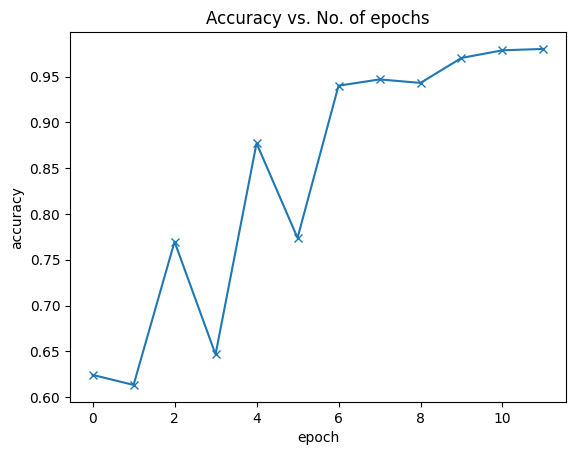

In [ ]:
plot_accuracies(history)

# **Plotting Losses vs Epochs**

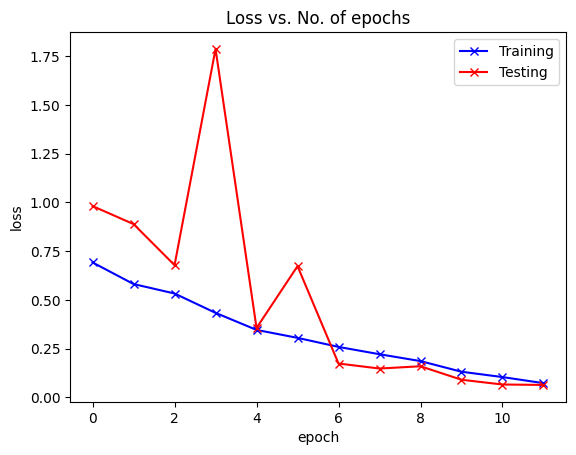

In [ ]:
plot_losses(history)

# **Visualising the learning rate**

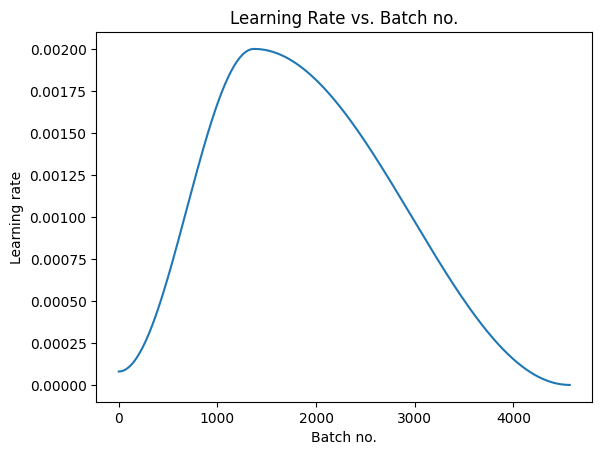

In [ ]:
plot_lrs(history)

# **Plotting Confusion Matrix**

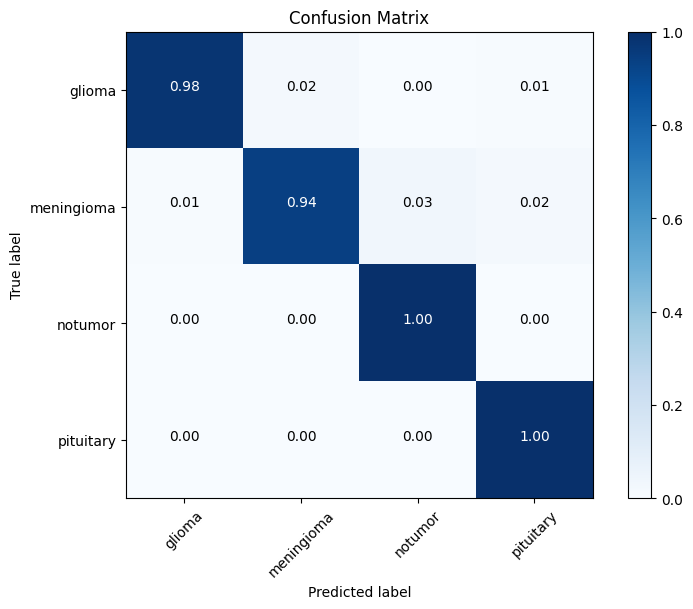

In [ ]:
plot_confusion_matrix(model_3)

# **F1 score,Precision and Recall**

In [ ]:
get_f1_prec_recall(model_3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Set - Precision: 0.9751, F1 Score: 0.9747, Recall: 0.9748


# **Model no 04 : Using Inbuilt Resnet 34 model**

In [ ]:
from torchvision import models
class Resnet_Model(ImageClassificationBase_2):
    def __init__(self, num_classes, pretrained=True):
            super().__init__()
            # Use a pretrained model
            self.network = models.resnet34(pretrained=pretrained)
            # Replace last layer
            self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_4=to_device(Resnet_Model(4),device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 67.3MB/s]


In [ ]:
%%time
history = [evaluate(model_4,test_dl)]
history

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CPU times: user 1.46 s, sys: 324 ms, total: 1.78 s
Wall time: 6.78 s


[{'test_loss': 1.678571105003357, 'test_acc': 0.25871211290359497}]

In [ ]:
epochs = 12
max_lr = 0.0020
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model_4, train_dl, test_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00042, train_loss: 0.3441, test_loss: 0.2448, test_acc: 0.9295
Epoch [1], last_lr: 0.00121, train_loss: 0.3409, test_loss: 0.4245, test_acc: 0.8341
Epoch [2], last_lr: 0.00187, train_loss: 0.3493, test_loss: 0.2818, test_acc: 0.9057
Epoch [3], last_lr: 0.00199, train_loss: 0.2677, test_loss: 0.2952, test_acc: 0.9004
Epoch [4], last_lr: 0.00187, train_loss: 0.2344, test_loss: 0.3066, test_acc: 0.8894
Epoch [5], last_lr: 0.00162, train_loss: 0.2031, test_loss: 0.1506, test_acc: 0.9436
Epoch [6], last_lr: 0.00129, train_loss: 0.1605, test_loss: 0.1057, test_acc: 0.9636
Epoch [7], last_lr: 0.00093, train_loss: 0.1320, test_loss: 0.0937, test_acc: 0.9697
Epoch [8], last_lr: 0.00057, train_loss: 0.1057, test_loss: 0.0672, test_acc: 0.9795
Epoch [9], last_lr: 0.00027, train_loss: 0.0656, test_loss: 0.0361, test_acc: 0.9902
Epoch [10], last_lr: 0.00007, train_loss: 0.0321, test_loss: 0.0258, test_acc: 0.9932
Epoch [11], last_lr: 0.00000, train_loss: 0.0219, test_loss: 0.0

# **Plotting the training and testing losses to study the trend**

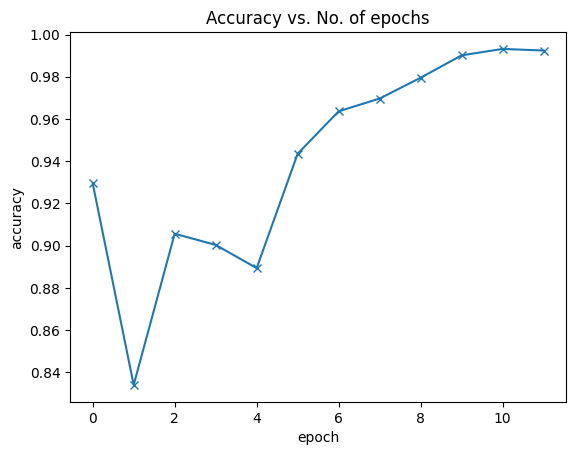

In [ ]:
plot_accuracies(history)

# **Plotting the training and testing losses to study the trend**

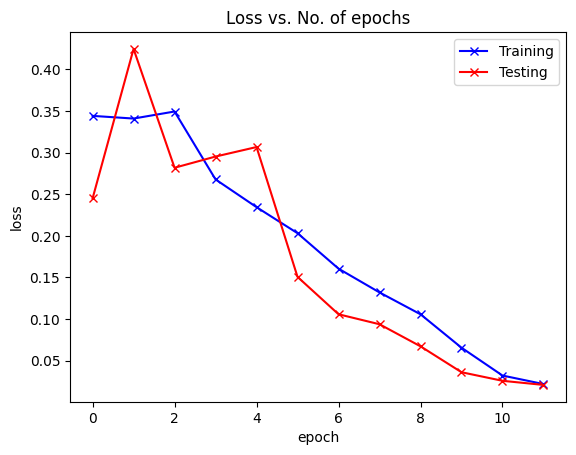

In [ ]:
plot_losses(history)

# **Visualize how the learning rate changed over time, batch-by-batch over all the epochs.**

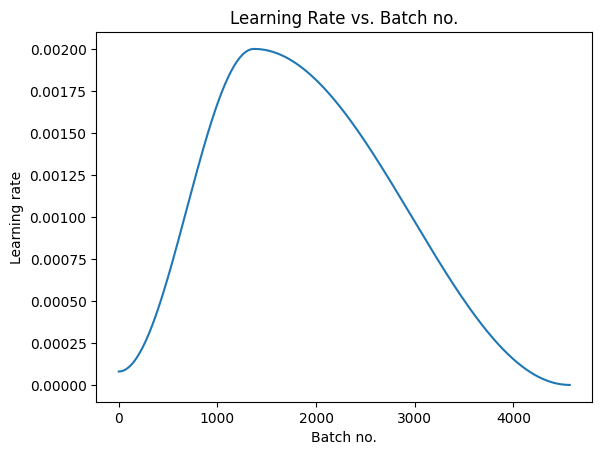

In [ ]:
plot_lrs(history)

# **Plotting the confusion matrix**

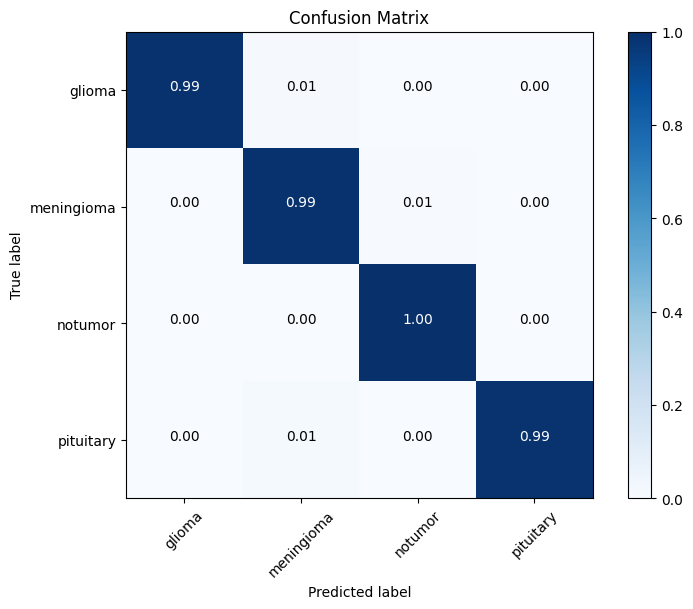

In [ ]:
plot_confusion_matrix(model_4)

# **F1 Score Precision and Recall**

In [ ]:
get_f1_prec_recall(model_4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Set - Precision: 0.9924, F1 Score: 0.9924, Recall: 0.9924


# **Saving the best Model i.e model no 04**

In [ ]:
torch.save(model_4.state_dict(), 'best_model_weights.pth')